In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

cmap = plt.get_cmap("Set1")
colors = cmap.colors

In [2]:
run_id, run_path = get_latest_results_directory("../../results/vary-nrects/")
# run_id = 1
# run_path = "C:/Users/Peter/Documents/Peter/9-Graduate-School/2-dsrg/explainable-ad/code/HEEAD/results/compare-methods/run-{:003d}".format(run_id)
fig_output_path = make_fig_directory(run_id)
found_ds, results = load_results(run_path, group_fields=["n_rects", "explainer"])

all_results = pd.DataFrame(columns=["dataset", "explainer", "n_samples", "n_samples_explained", "n_features", "accuracy", "precision", "recall", "f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard", "coverage_ratio", "mean_distance", "mean_length", "runtime", "clique_size", "init_time", "sample_runtime", "mdr", "n_rects", "n_trees"])

for ds in found_ds:
    results[ds]["sample_runtime"] = results[ds].runtime / results[ds].n_samples_explained
    results[ds]["init_time"] = results[ds]["init_time"]
    results[ds]["mdr"] = results[ds].mean_distance
    # results[ds]["mdr"] = results[ds].mean_distance / np.sqrt(results[ds].n_features)

for ds in found_ds:
    for index, row in results[ds].iterrows():
        row["dataset"] = ds
        all_results = all_results.append(row)
idx_neg = all_results["clique_size"] < 0
all_results.loc[idx_neg, "clique_size"] = 0

found_explainers = all_results["explainer"].unique()
explainer_dict = {
    "AFT" : "AFT",
    "FACET" : "FACET",
    "FACETPaths" : "FACETPaths",
    "FACETTrees" : "FACETTrees",
    "FACETGrow" : "FACETGrow",
    "FACETIndex": "FACETIndex",
    "OCEAN" : "OCEAN",
    "MACE": "MACE"
}
explainer_colors = {
    "AFT" : colors[3] , # purple
    "FACET" : colors[0], # red
    "FACETPaths" : colors[0], # red
    "FACETTrees" : colors[0], # red
    "FACETGrow" : colors[0], # red
    "FACETIndex" : colors[0], # red
    "OCEAN" : colors[4], # orange
    "MACE": colors[1] # blue
}
explainer_names = []
for e in found_explainers:
    explainer_names.append(explainer_dict[e])

print("Generating figures for run-{:03d}".format(run_id))
print("Datasets included:")
for ds in found_ds:
    print("\t", ds)
print("Explainers included:")
for expl in found_explainers:
    print("\t", expl)

Generating figures for run-030
Datasets included:
	 cancer
	 glass
	 magic
Explainers included:
	 FACETIndex


In [3]:
all_results.head()

,dataset,explainer,n_samples,n_samples_explained,n_features,accuracy,precision,recall,f1,avg_nnodes,...,sample_runtime,mdr,n_rects,n_trees,cover_xtest,cover_xtrain,ext_avg,ext_max,ext_min,grown_clique_size
0,cancer,FACETIndex,20,20,30,0.95,1.0,0.666667,0.8,12.3,...,0.001700,0.417503,100,100,0.00,0.000000,-1.0,-1.0,-1.0,-1.0
1,cancer,FACETIndex,20,20,30,0.95,1.0,0.666667,0.8,12.3,...,0.010200,0.388558,1000,100,0.10,0.015419,-1.0,-1.0,-1.0,-1.0
2,cancer,FACETIndex,20,20,30,0.95,1.0,0.666667,0.8,12.3,...,0.049700,0.330560,5000,100,0.00,0.000000,-1.0,-1.0,-1.0,-1.0
3,cancer,FACETIndex,20,20,30,0.95,1.0,0.666667,0.8,12.3,...,0.099963,0.322938,10000,100,0.05,0.039648,-1.0,-1.0,-1.0,-1.0
4,cancer,FACETIndex,20,20,30,0.95,1.0,0.666667,0.8,12.3,...,0.197866,0.312981,20000,100,0.10,0.092511,-1.0,-1.0,-1.0,-1.0


In [4]:
def render_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None):
    plt.figure()

    for i in range(len(found_ds)):
        ds = found_ds[i]
        is_ds = all_results["dataset"] == ds

        plt.plot(all_results[is_ds][xfeature], all_results[is_ds][yfeature], label=ds, lw=2.0)

    # if xlog:
    #     plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    if xrange is not None:
        plt.xlim(xrange)
    if yrange is not None:
        plt.ylim(yrange)
    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name, bbox_inches="tight")

In [5]:
def render_bar_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None):
    fig, ax = plt.subplots()
    pos = np.arange(len(found_ds))
    bar_width = 0.15

    yvalues = all_results[yfeature].unique()

    for i in range(len(yvalues)):
        isExpl = all_results[yfeature] == yvalues[i]
        hbars = ax.barh(y=(pos + bar_width*i), width=all_results[isExpl][xfeature], height=bar_width, log=xlog, color=explainer_colors[yvalues[i]])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if not lloc:
        lloc = "best"
    plt.legend(explainer_names, loc=lloc)
    plt.yticks(pos, found_ds)

    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name, bbox_inches="tight")

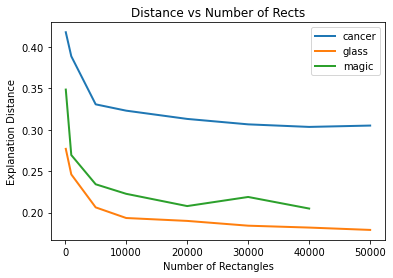

In [6]:
render_plot(xfeature="n_rects", yfeature="mdr", xlabel="Number of Rectangles", ylabel="Explanation Distance", title="Distance vs Number of Rects", save_name="distance_rects.png")

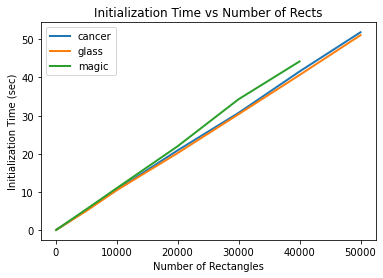

In [7]:
render_plot(xfeature="n_rects", yfeature="init_time", xlabel="Number of Rectangles", ylabel="Initialization Time (sec)", title="Initialization Time vs Number of Rects", save_name="inittime_rects.png")

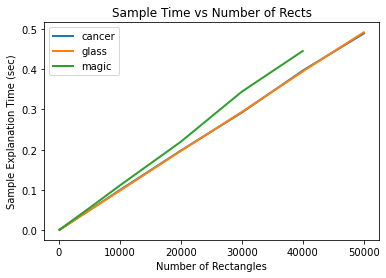

In [8]:
render_plot(xfeature="n_rects", yfeature="sample_runtime", xlabel="Number of Rectangles", ylabel="Sample Explanation Time (sec)", title="Sample Time vs Number of Rects", save_name="runtime_rects.png")

In [9]:
results["cancer"]

,n_rects,explainer,n_trees,n_samples,n_samples_explained,n_features,accuracy,precision,recall,f1,...,runtime,clique_size,grown_clique_size,ext_min,ext_avg,ext_max,cover_xtrain,cover_xtest,sample_runtime,mdr
0,100,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,0.034002,-1,-1,-1,-1,-1,0.000000,0.00,0.001700,0.417503
1,1000,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,0.204009,-1,-1,-1,-1,-1,0.015419,0.10,0.010200,0.388558
2,5000,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,0.994000,-1,-1,-1,-1,-1,0.000000,0.00,0.049700,0.330560
3,10000,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,1.999255,-1,-1,-1,-1,-1,0.039648,0.05,0.099963,0.322938
4,20000,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,3.957310,-1,-1,-1,-1,-1,0.092511,0.10,0.197866,0.312981
5,30000,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,5.845079,-1,-1,-1,-1,-1,0.028634,0.05,0.292254,0.306428
6,40000,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,7.926665,-1,-1,-1,-1,-1,0.187225,0.35,0.396333,0.303342
7,50000,FACETIndex,100,20,20,30,0.95,1.0,0.666667,0.8,...,9.767033,-1,-1,-1,-1,-1,0.103524,0.05,0.488352,0.304967


In [10]:
all_results[["dataset", "cover_xtrain"]].head()

,dataset,cover_xtrain
0,cancer,0.000000
1,cancer,0.015419
2,cancer,0.000000
3,cancer,0.039648
4,cancer,0.092511


In [11]:
all_results[["dataset", "cover_xtest"]].head()

,dataset,cover_xtest
0,cancer,0.00
1,cancer,0.10
2,cancer,0.00
3,cancer,0.05
4,cancer,0.10
